In [113]:
import glob
import pandas as pd
import os as os
import matplotlib.pyplot as plt


path =r'Data/russian_tweets/'
allFiles = glob.glob(os.path.join(path, "*.csv"))
troll = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
troll = pd.concat(list_)

In [114]:
print troll.shape

(2973371, 15)


In [98]:
troll.isnull().sum().sort_values(ascending = False)

post_type             1662425
region                   8843
account_type              363
external_author_id          4
content                     1
account_category            0
retweet                     0
new_june_2018               0
updates                     0
followers                   0
following                   0
harvested_date              0
publish_date                0
language                    0
author                      0
dtype: int64

In [9]:
print(troll.dtypes)

external_author_id    float64
author                 object
content                object
region                 object
language               object
publish_date           object
harvested_date         object
following               int64
followers               int64
updates                 int64
post_type              object
account_type           object
new_june_2018           int64
retweet                 int64
account_category       object
dtype: object


In [11]:
troll['publish_date'] = pd.to_datetime(troll['publish_date'])

In [13]:
start_date_tweet = troll['publish_date'].min()
end_date_tweet = troll['publish_date'].max()
print start_date_tweet,end_date_tweet

2012-02-02 00:35:00 2018-05-30 21:01:00


In [14]:
troll['created_str_date'] = pd.to_datetime(troll['publish_date'].dt.date)

In [15]:
# Count the number of times a date appears in the dataset and convert to dataframe
tweet_trend = pd.DataFrame(troll['created_str_date'].value_counts())

# index is date, columns indicate tweet count on that day
tweet_trend.columns = ['tweet_count']

# sort the dataframe by the dates to have them in order
tweet_trend.sort_index(ascending = True, inplace = True)

In [26]:
print tweet_trend['tweet_count'].sort_values(ascending=False).head(15)

2016-10-06    18722
2017-08-16    14720
2017-08-15    13375
2017-08-17    13066
2017-08-12    12981
2017-08-18    12470
2017-08-13    10981
2017-08-14    10700
2016-10-07    10356
2015-07-22     9564
2016-09-19     9298
2017-08-10     8738
2017-08-07     8717
2015-11-27     8709
2017-08-09     8689
Name: tweet_count, dtype: int64


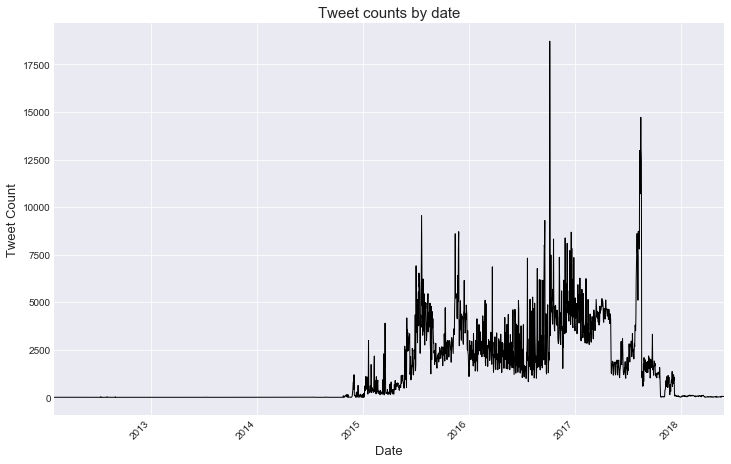

In [27]:
plt.style.use('seaborn-darkgrid')
tweet_trend['tweet_count'].plot(linestyle = "-", figsize = (12,8), rot = 45, color = 'k',
                               linewidth = 1)
plt.title('Tweet counts by date', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)

In [29]:
dates_list = ['2015-11-27', '2015-07-22', '2016-02-01',
              '2017-08-16', '2017-08-17', '2016-03-11',
              '2016-05-03', '2016-05-26', '2016-06-20', 
              '2016-07-15', '2016-07-21', '2016-08-17',
              '2016-09-19', '2016-10-07', '2016-10-06']

# create a series of these dates.
important_dates = pd.Series(pd.to_datetime(dates_list))

# add columns to identify important events, and mark a 0 or 1.
tweet_trend['Important Events'] = False
tweet_trend.loc[important_dates, 'Important Events'] = True
tweet_trend['values'] = 0
tweet_trend.loc[important_dates, 'values'] = 1

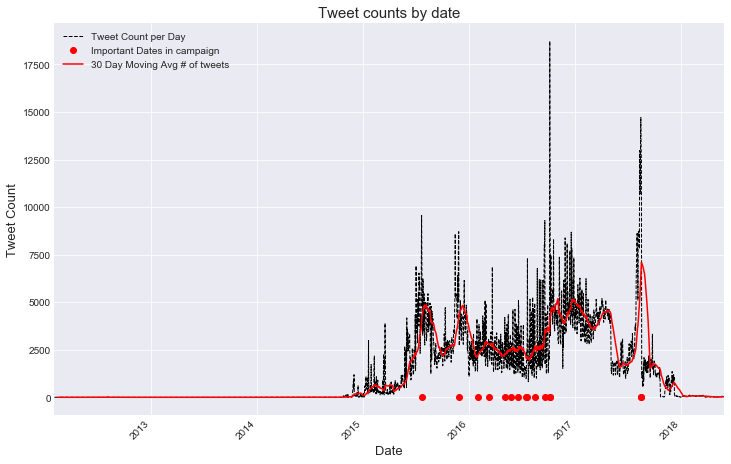

In [30]:
plt.style.use('seaborn-darkgrid')
tweet_trend['tweet_count'].plot(linestyle = "--", 
                                figsize = (12,8), rot = 45, 
                                color = 'k',
                                label = 'Tweet Count per Day',
                               linewidth = 1)

# plot dots for where values in the tweet_trend df are 1
plt.plot(tweet_trend[tweet_trend['Important Events'] == True].index.values,
         tweet_trend.loc[tweet_trend['Important Events'] == True, 'values'],
         marker = 'o', 
         color = 'r',
         linestyle = 'none',
        label = 'Important Dates in campaign')

# Lets add a 30 day moving average on top to view the trend! Min_periods tells rolling() to
# use 10 points if 30 not available!
plt.plot(tweet_trend['tweet_count'].rolling(window = 30, min_periods = 10).mean(), 
         color = 'r', 
         label = '30 Day Moving Avg # of tweets')
plt.title('Tweet counts by date', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)
plt.legend(loc = 'best')

In [92]:
troll['content'].head(10)

Series([], Name: content, dtype: object)

In [111]:
troll.dropna(subset = ['content'], inplace = True)
trolls = troll.query('account_category == "RightTroll" |account_category == "LeftTroll" | account_category == "NewsFeed"')
print trolls.shape
import re
def remove_retweet(tweet):
    '''Given a tweet, remove the retweet element from it'''
    text_only = []
    if len(re.findall("^RT.*?:(.*)", tweet)) > 0:
        text_only.append(re.findall("^RT.*?:(.*)", tweet)[0])
    else:
        text_only.append(tweet)
    return text_only[0]

# extract texts and place in a list
text_only = trolls.query('language=="English"')['content'].map(remove_retweet)

(1746192, 15)


In [106]:
print text_only.shape

(1732807,)


In [107]:
def remove_links(tweet):
    '''Provide a tweet and remove the links from it'''
    text_only = []
    if len(re.findall("(https://[^\s]+)", tweet)) > 0:
        tweet = re.sub("(https://[^\s]+)", "", tweet)
    if len(re.findall("(http://[^\s]+)", tweet)) > 0:
        tweet = re.sub("(http://[^\s]+)", "", tweet)    
    text_only.append(tweet)
    return text_only[0]

text_no_links = text_only.map(remove_links)

In [44]:
def remove_hashtags(tweet):
    '''Provide a tweet and remove hashtags from it'''
    hashtags_only = []
    if len(re.findall("(#[^#\s]+)", tweet)) > 0:
        tweet = re.sub("(#[^#\s]+)", "", tweet) 
    hashtags_only.append(tweet)
    return hashtags_only[0]

text_all_removed = text_no_links.map(remove_hashtags)

In [45]:
def remove_extraneous(tweet):
    '''Given a text, remove unnecessary characters from the beginning and the end'''
    tweet = tweet.rstrip()
    tweet = tweet.lstrip()
    tweet = tweet.rstrip(")")
    tweet = tweet.lstrip("(")
    tweet = re.sub("\.", "", tweet)
    return tweet

text_clean = text_all_removed.map(remove_extraneous)

In [56]:
print text_clean_final
def remove_mentions(tweet):
    '''Given a text, remove the user mentions'''
    mentions = []
    if len(re.findall('@[^\s@]+', tweet))>0:
        tweet = re.sub('@[^\s@]+', "" , tweet)
        mentions.append(tweet)
    else:
        mentions.append(tweet)
    return mentions[0]

text_clean_final = text_clean.map(remove_mentions)

0        People are too toxic I think I have people poi...
1                  Don't Shoot (I'm a Man) by  -  - Buy it
2        the 'I'm the most boring person in the world' ...
4        Boring narcissistsnothing wrong with narcissis...
5        Your opinion on Hillary really matters to a no...
6                                 Lilith from Frasier  0_O
7        Come find us at the national mall for the   fo...
8        Trolling celebrities  I have been blocked by W...
9                                          Morbid comedy �
10                         Yo momma in her Beyonce costume
11                                        a woman in heels
12              Sometimes seeing things in black and white
13       Making horrible jokes that only 10% of people ...
14       Came back to 2016 to stop horrific Graham vs O...
15       Where did I leave my car takes on whole new me...
16                 Business in the front party in the back
17       I declared Thumb War, she dropped her clothes .

In [57]:
text_clean_final.shape
#text_clean[text_clean.index.duplicated()]
#troll['tweet_text_only'] = text_clean_final

(2128962,)

In [127]:
def extract_hashtags(tweet):
    '''Provide a tweet and extract hashtags from it'''
    hashtags_only = []
    if len(re.findall("(#[^#\s]+)", tweet)) > 0:
        hashtags_only.append(re.findall("(#[^#\s]+)", tweet))
    else:
        hashtags_only.append(["0"])
    return hashtags_only[0]

# make a new column to store the extracted hashtags and view them!
tweet_hashtags = troll.query('account_category == "RightTroll" |account_category == "LeftTroll" | account_category == "NewsFeed"')['content'].map(extract_hashtags)
#troll['tweet_hashtags'].head(10)

In [128]:
print tweet_hashtags

2028                                                   [0]
2029                                                   [0]
2030                                                   [0]
2031                                                   [0]
2032                                                   [0]
2033                                                   [0]
2034                                                   [0]
2035                       [#MarcusTulliusCicero:, #quote]
2036                                                   [0]
2037                                                   [0]
2038                                                   [0]
2039                                                   [0]
2040                                                   [0]
2041                                                   [0]
2042                                                   [0]
2043                                                   [0]
2044                                                   [

In [129]:
# create a list of all hashtags
all_hashtags = tweet_hashtags

# Next we observe that our all_hashtags is a list of lists...lets change that
cleaned_hashtags = []
for i in all_hashtags:
    for j in i:
            cleaned_hashtags.append(j)

# Convert cleaned_hashtags to a series and count the most frequent occuring
cleaned_hashtag_series = pd.Series(cleaned_hashtags)
hashtag_counts = cleaned_hashtag_series.value_counts()

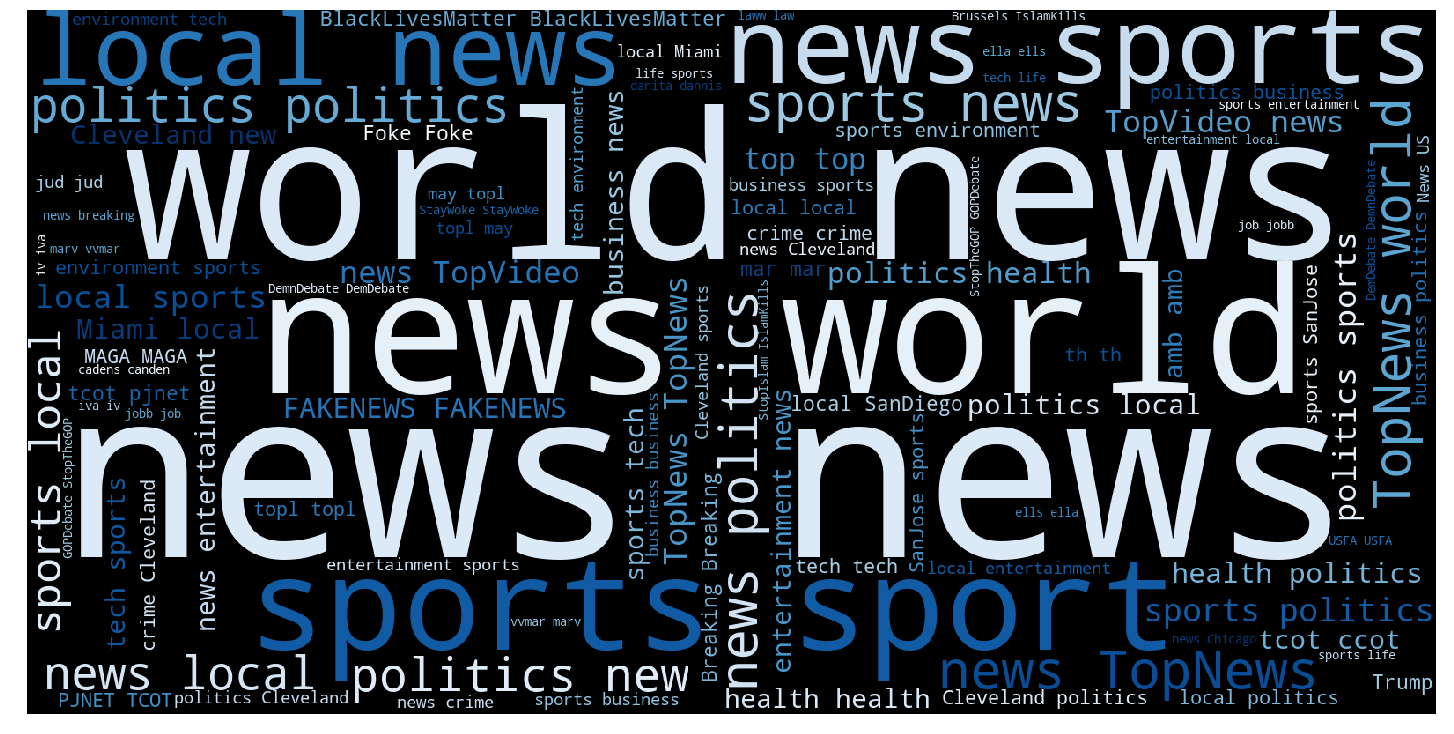

In [170]:
hashes = cleaned_hashtag_series.values
hashes = hashes.tolist()
hashes= filter(lambda a: a != '0', hashes)

# convert list to one string with all the words
hashes_words = " ".join(hashes)

# generate the wordcloud. the max_words argument controls the number of words on the cloud
from wordcloud import WordCloud
wordcloud = WordCloud(width= 1600, height = 800, 
                      relative_scaling = 0.3, 
                      colormap = "Blues",
                     max_words = 100).generate(hashes_words)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [176]:
from collections import Counter
print Counter(hashes)

Counter({'#news': 127016, '#sports': 48587, '#politics': 39717, '#world': 27540, '#local': 25806, '#TopNews': 15159, '#MAGA': 12366, '#health': 11448, '#tcot': 11210, '#BlackLivesMatter': 11190, '#business': 10816, '#PJNET': 10331, '#tech': 8217, '#entertainment': 7577, '#top': 7486, '#Cleveland': 6689, '#TopVideo': 6553, '#crime': 6497, '#environment': 5785, '#ISIS': 4939, '#mar': 4920, '#Miami': 4535, '#breaking': 4497, '#topl': 4416, '#Trump': 4179, '#SanJose': 4154, '#IslamKills': 4126, '#2A': 3980, '#WakeUpAmerica': 3947, '#life': 3920, '#FAKENEWS!': 3753, '#GOPDebate': 3678, '#NowPlaying': 3457, '#TCOT': 3434, '#ccot': 3293, '#Chicago': 3212, '#amb': 2949, '#TrumpTrain': 2678, '#may': 2601, '#Texas': 2558, '#p2': 2543, '#US': 2506, '#DemnDebate': 2501, '#SanDiego': 2428, '#Foke': 2416, '#pjnet': 2321, '#VegasGOPDebate': 2293, '#Trump2016': 2257, '#DemDebate': 2249, '#CCOT': 2242, '#Syria': 2218, '#Wisconsin': 2168, '#News': 2156, '#th': 2126, '#Brussels': 2091, '#BlackTwitter': 1

In [252]:
i=0
value1=[]
value2=[]
for x in Counter(hashes).most_common(100):
    value1.append(x[0])
    value2.append(x[1])
print value1
print value2
df = pd.DataFrame({'hashtag':value1,'count':value2})

['#news', '#sports', '#politics', '#world', '#local', '#TopNews', '#MAGA', '#health', '#tcot', '#BlackLivesMatter', '#business', '#PJNET', '#tech', '#entertainment', '#top', '#Cleveland', '#TopVideo', '#crime', '#environment', '#ISIS', '#mar', '#Miami', '#breaking', '#topl', '#Trump', '#SanJose', '#IslamKills', '#2A', '#WakeUpAmerica', '#life', '#FAKENEWS!', '#GOPDebate', '#NowPlaying', '#TCOT', '#ccot', '#Chicago', '#amb', '#TrumpTrain', '#may', '#Texas', '#p2', '#US', '#DemnDebate', '#SanDiego', '#Foke', '#pjnet', '#VegasGOPDebate', '#Trump2016', '#DemDebate', '#CCOT', '#Syria', '#Wisconsin', '#News', '#th', '#Brussels', '#BlackTwitter', '#Obama', '#NeverHillary', '#NowPlaying:', '#USFA', '#StLouis', '#BLM', '#OscarHasNoColor', '#StopTheGOP', '#money', '#TrumpForPresident', '#PoliceBrutality', '#jud', '#StopIslam', '#Prayers4California', '#blacklivesmatter', '#MakeAmericaGreatAgain', '#Breaking', '#art', '#imo', '#StayWoke', '#RT', '#CruzCrew', '#MAGA!', '#TrumpBecause', '#BlackSkinI

Axes(0.125,0.125;0.775x0.755)


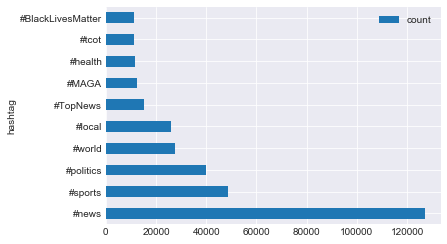

In [258]:
print df.head(10).plot(x='hashtag',y='count',kind='barh')

In [254]:
d = {}
for a, x in df.values:
    d[x]=a
print d

{'#TrumpPence16': 1269, '#Hillary': 1372, '#GOPDebate': 3678, '#PoliceBrutality': 1680, '#MakeAmericaGreatAgain': 1611, '#Chicago': 3212, '#breaking': 4497, '#TrumpTrain': 2678, '#music': 1275, '#love': 1227, '#amb': 2949, '#Miami': 4535, '#crime': 6497, '#CruzCrew': 1414, '#topl': 4416, '#world': 27540, '#Cleveland': 6689, '#tcot': 11210, '#th': 2126, '#soundcloud': 1343, '#StLouis': 1825, '#politics': 39717, '#PJNET': 10331, '#StopTheGOP': 1750, '#art': 1514, '#life': 3920, '#just': 1280, '#TCOT': 3434, '#NoDAPL': 1401, '#money': 1712, '#mar': 4920, '#may': 2601, '#BlackSkinIsNotACrime': 1405, '#Aleppo': 1271, '#2A': 3980, '#environment': 5785, '#Wisconsin': 2168, '#Breaking': 1556, '#DrainTheSwamp': 1229, '#News': 2156, '#MAGA!': 1407, '#BlackTwitter': 1990, '#VegasGOPDebate': 2293, '#BLM': 1812, '#TopVideo': 6553, '#BlackLivesMatter': 11190, '#p2': 2543, '#OscarHasNoColor': 1779, '#StayWoke': 1464, '#SAA': 1331, '#sports': 48587, '#DemDebate': 2249, '#TopNews': 15159, '#jud': 1671,

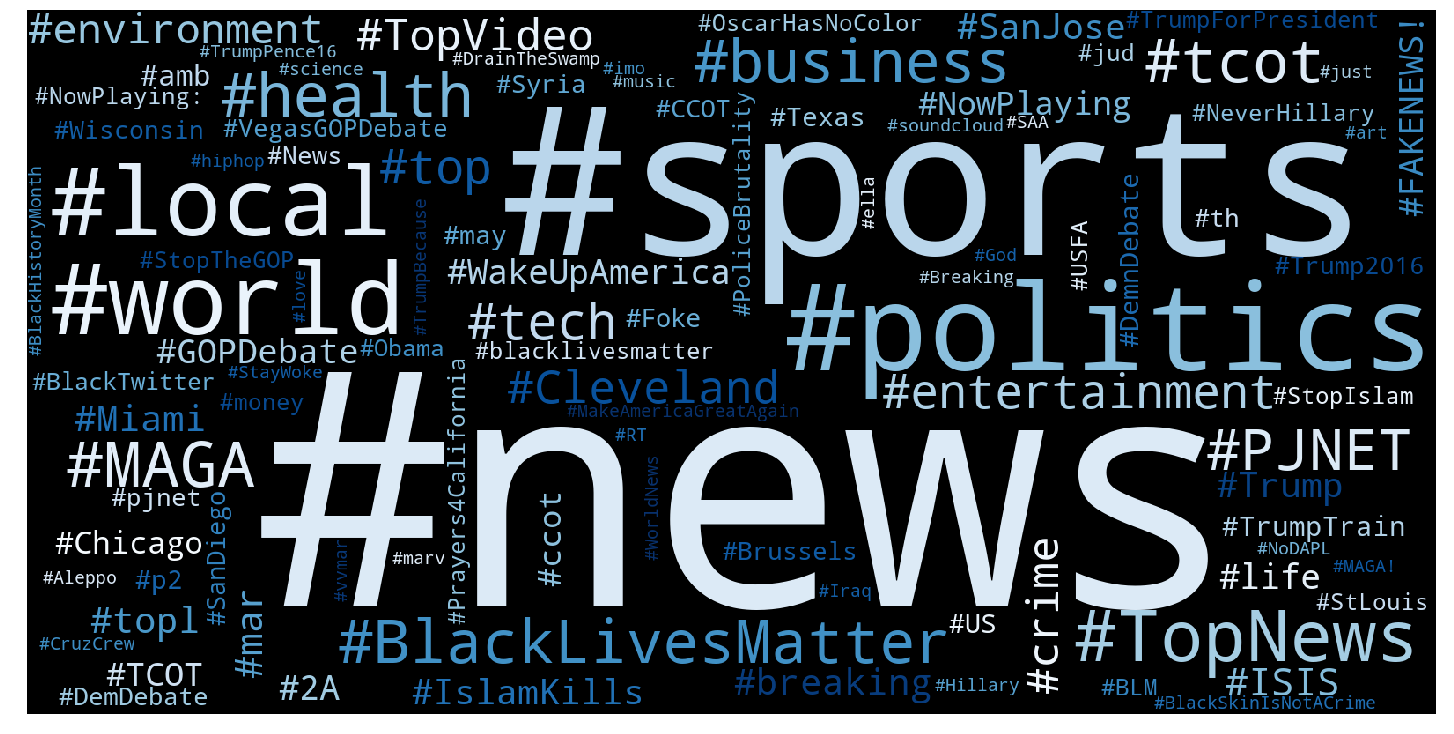

In [257]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width= 1600, height = 800, 
                      relative_scaling = 0.6, 
                      colormap = "Blues",
                     max_words = 100).generate_from_frequencies(frequencies=d)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()